In [1]:
import matplotlib.pyplot as plt
import numpy
import tensorflow as tf
from matplotlib import pyplot as flt
import tensorflow_datasets as tfds
from PIL import Image, ImageFont, ImageDraw
import numpy as np

2023-08-23 19:50:07.401035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-23 19:50:08.349110: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
total_image_width = 75
total_image_height = 75

og_image_width = 28
og_image_height = 28

max_padded_start_left = total_image_width - og_image_width - 1
max_padded_start_top = total_image_height - og_image_height - 1

BATCH_SIZE = 64

In [3]:
def draw_bounding_boxes_using_normalized_coords(image_arr: np.ndarray, boxes: np.ndarray):
    image = Image.fromarray(np.squeeze(image_arr, axis=-1))
    # image = image.convert("RGB")
    for box in boxes:
        draw = ImageDraw.Draw(image)
        x_coords = box[:2] * total_image_width
        y_coords = box[2:] * total_image_height
        left, right = x_coords
        top, bottom = y_coords

        draw.line(((left, top), (left, bottom), (right, bottom), (right, top), (left, top)))
    return np.array(image)

In [13]:
def get_datasets():
    def raw_to_padded(image: np.ndarray, label):
        left, top = (tf.random.uniform((), 0, max_start, dtype=tf.int32) for max_start in (max_padded_start_left, max_padded_start_top))
        image = tf.reshape(image, (28, 28, 1))
        padded = tf.image.pad_to_bounding_box(image, top, left, total_image_width, total_image_height)
        normalized = tf.cast(padded, tf.float32)/255
        right = left + og_image_width
        bottom = top + og_image_height
        coords = [tf.cast(coord, tf.float32) / total_image_width for coord in (left, right, top, bottom)]
        # coords = [left, right, top, bottom]
        return normalized, (tf.one_hot(label, 10), coords)
    
    def process_padded_datasets(dataset: tf.data.Dataset):
        dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
        dataset = dataset.repeat()
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(-1)
        return dataset
        
    original_datasets = (tfds.load('mnist', split=split, as_supervised=True) for split in ('train', 'test'))
    padded_datasets = (dataset.map(raw_to_padded, num_parallel_calls=16) for dataset in original_datasets)
    train_dataset, validation_dataset = (process_padded_datasets(dataset) for dataset in padded_datasets)
    
    return train_dataset, validation_dataset
    
train_dataset, validation_dataset = get_datasets()
train_dataset, validation_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 1), dtype=tf.float32, name=None), (TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>)

2023-08-23 19:50:16.684903: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


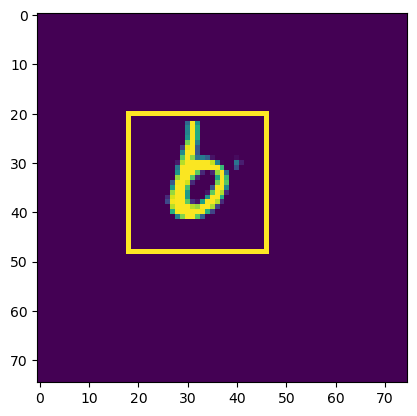

In [5]:
sample_images, (sample_labels, sample_coordss) = next(validation_dataset.take(1).as_numpy_iterator())
sample_image = sample_images[0]
sample_label = sample_images[0]
sample_coords = sample_coordss[0]

boxed_sample_image = draw_bounding_boxes_using_normalized_coords(sample_image, np.array([sample_coords]))
plt.imshow(boxed_sample_image)

In [15]:
def make_model():    
    def feature_extractor(inputs):
        last_layer = inputs
        for filter in [16, 32, 32]:
            conv = tf.keras.layers.Conv2D(filter, (3, 3), activation='relu')(last_layer)
            pool = tf.keras.layers.AvgPool2D((2, 2))(conv)
            last_layer = pool
        return last_layer
    
    def fc_layers(inputs):
        flatten = tf.keras.layers.Flatten()(inputs)
        dense = tf.keras.layers.Dense(128, activation='relu')(flatten)
        return dense
    
    def classifier(inputs):
        classification_output = tf.keras.layers.Dense(10, activation='softmax', name='classification')(inputs)
        return classification_output
    
    def box_regressioner(inputs):
        box_regression_output = tf.keras.layers.Dense(4, name='box_coords')(inputs)
        return box_regression_output
        
    model_inputs = tf.keras.layers.Input(shape=(total_image_width, total_image_height, 1))
    features = feature_extractor(model_inputs)
    fc = fc_layers(features)
    classification = classifier(fc)
    box_coords = box_regressioner(fc)
    model = tf.keras.models.Model(inputs=model_inputs, outputs=[classification, box_coords])
    return model

model = make_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 73, 73, 16)           160       ['input_4[0][0]']             
                                                                                                  
 average_pooling2d_9 (Avera  (None, 36, 36, 16)           0         ['conv2d_9[0][0]']            
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_10 (Conv2D)          (None, 34, 34, 32)           4640      ['average_pooling2d_9[0]

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss={
        'classification': 'categorical_crossentropy',
        'box_coords': 'mse'
    },
    metrics={
        'classification': 'acc',
        'box_coords': 'mse'
    }
)

In [18]:
eps = 5
steps_per_epoch = 5000

history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, epochs=eps, validation_steps=1)

Epoch 1/5
5000/5000 [==============================] - 32s 6ms/step - loss: 0.0693 - classification_loss: 0.0683 - box_coords_loss: 0.0010 - classification_acc: 0.9791 - box_coords_mse: 0.0010 - val_loss: 0.0561 - val_classification_loss: 0.0554 - val_box_coords_loss: 6.6309e-04 - val_classification_acc: 0.9844 - val_box_coords_mse: 6.6309e-04
Epoch 2/5
  27/5000 [..............................] - ETA: 31s - loss: 0.0489 - classification_loss: 0.0479 - box_coords_loss: 9.6914e-04 - classification_acc: 0.9844 - box_coords_mse: 9.6914e-04

2023-08-23 19:55:40.783757: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5000/5000 [==============================] - 33s 7ms/step - loss: 0.0522 - classification_loss: 0.0513 - box_coords_loss: 9.1698e-04 - classification_acc: 0.9840 - box_coords_mse: 9.1698e-04 - val_loss: 0.0169 - val_classification_loss: 0.0162 - val_box_coords_loss: 7.8213e-04 - val_classification_acc: 1.0000 - val_box_coords_mse: 7.8213e-04
Epoch 3/5
  27/5000 [..............................] - ETA: 31s - loss: 0.0549 - classification_loss: 0.0540 - box_coords_loss: 9.4420e-04 - classification_acc: 0.9844 - box_coords_mse: 9.4420e-04

2023-08-23 19:56:13.888568: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5000/5000 [==============================] - 34s 7ms/step - loss: 0.0427 - classification_loss: 0.0418 - box_coords_loss: 9.0515e-04 - classification_acc: 0.9870 - box_coords_mse: 9.0515e-04 - val_loss: 0.0212 - val_classification_loss: 0.0204 - val_box_coords_loss: 8.0258e-04 - val_classification_acc: 0.9844 - val_box_coords_mse: 8.0258e-04
Epoch 4/5
  24/5000 [..............................] - ETA: 35s - loss: 0.0420 - classification_loss: 0.0410 - box_coords_loss: 0.0010 - classification_acc: 0.9863 - box_coords_mse: 0.0010        

2023-08-23 19:56:47.780502: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5000/5000 [==============================] - 35s 7ms/step - loss: 0.0366 - classification_loss: 0.0357 - box_coords_loss: 8.9321e-04 - classification_acc: 0.9889 - box_coords_mse: 8.9321e-04 - val_loss: 0.1128 - val_classification_loss: 0.1115 - val_box_coords_loss: 0.0013 - val_classification_acc: 0.9531 - val_box_coords_mse: 0.0013
Epoch 5/5
  24/5000 [..............................] - ETA: 35s - loss: 0.0262 - classification_loss: 0.0254 - box_coords_loss: 8.1015e-04 - classification_acc: 0.9928 - box_coords_mse: 8.1015e-04

2023-08-23 19:57:22.586132: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


5000/5000 [==============================] - 35s 7ms/step - loss: 0.0319 - classification_loss: 0.0310 - box_coords_loss: 8.8275e-04 - classification_acc: 0.9905 - box_coords_mse: 8.8275e-04 - val_loss: 0.0612 - val_classification_loss: 0.0603 - val_box_coords_loss: 9.6245e-04 - val_classification_acc: 0.9688 - val_box_coords_mse: 9.6245e-04


2023-08-23 19:57:57.370330: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


1/1 [==============================] - 0s 16ms/step
[[1.65254392e-07 1.44440304e-09 1.55307077e-06 4.06577300e-10
  1.06438485e-04 8.13111978e-09 8.63468186e-11 7.27363158e-06
  1.41006121e-05 9.99870420e-01]] [[0.38265902 0.755993   0.32006353 0.6934018 ]]


2023-08-23 20:09:55.981525: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


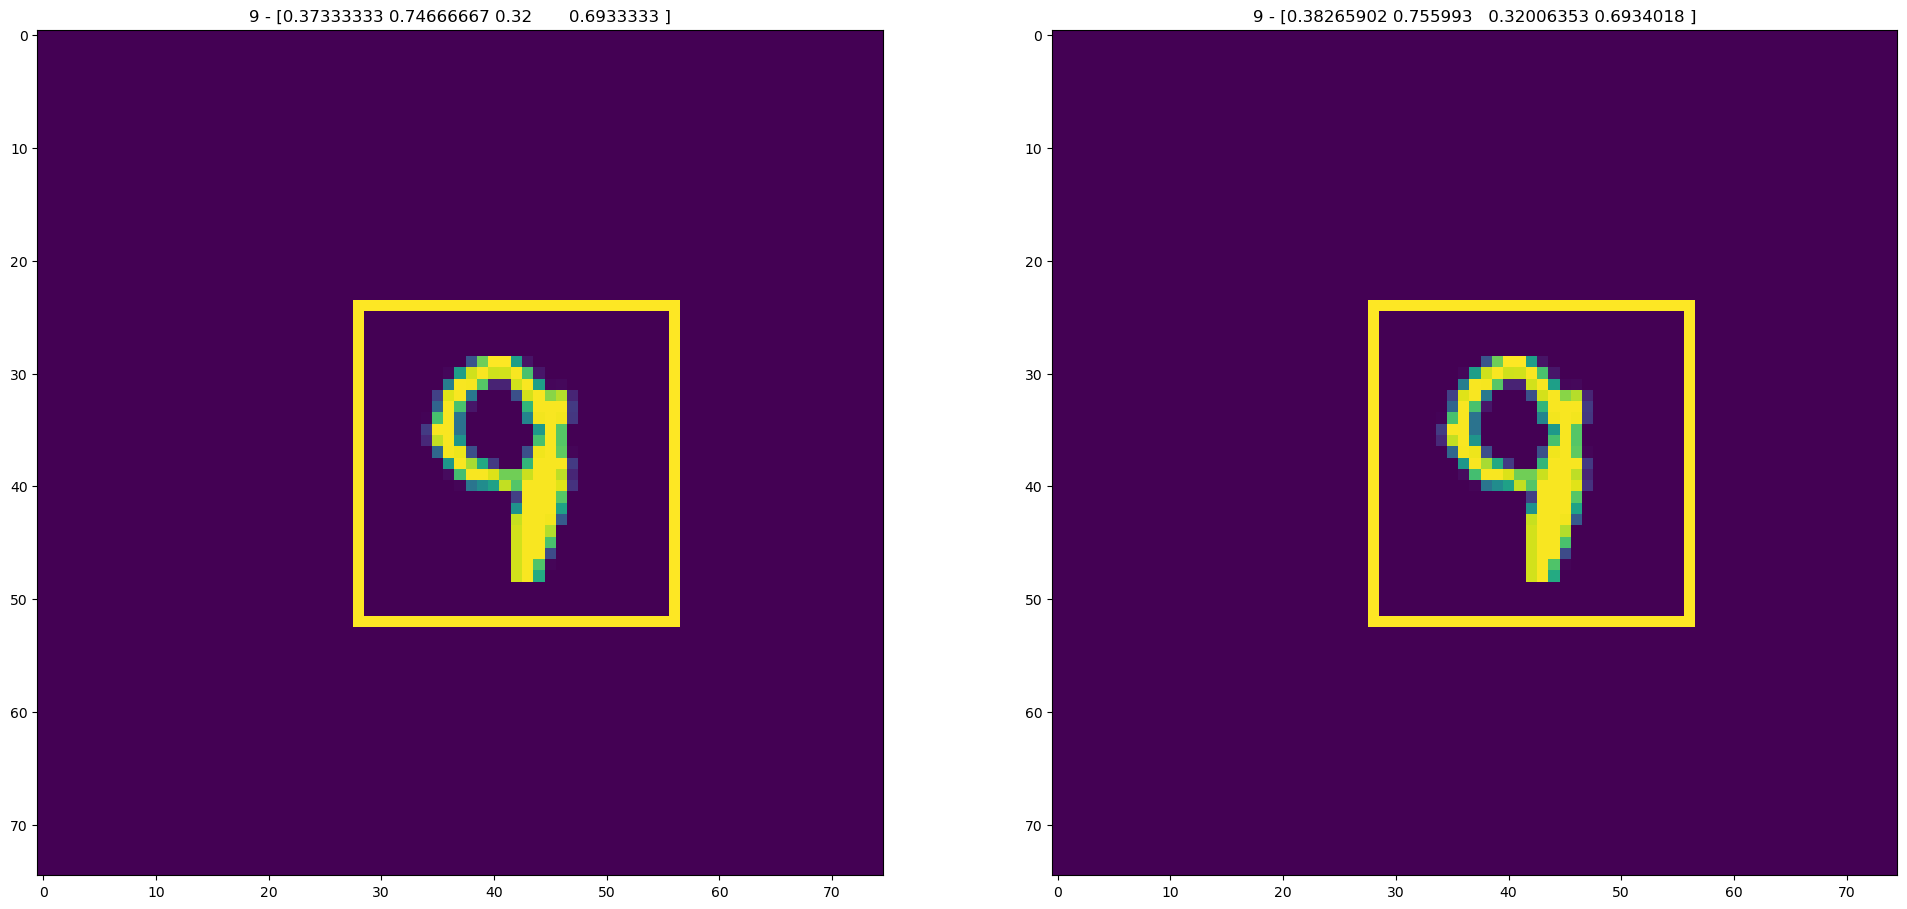

In [37]:
sample_images, (sample_labels, sample_coordss) = next(validation_dataset.take(1).as_numpy_iterator())
sample_image = sample_images[0]
sample_label = np.argmax(sample_labels[0])
sample_coords = sample_coordss[0]

boxed_sample_image = draw_bounding_boxes_using_normalized_coords(sample_image, np.array([sample_coords]))

predicted_labels, predicted_coordss = model.predict(np.array([sample_image]))
print(predicted_labels, predicted_coordss)
predicted_coords = predicted_coordss[0]
predicted_label = numpy.argmax(predicted_labels[0])

fig, axes = plt.subplots(1, 2, figsize=(24, 12))

axes[0].set_title(f"{sample_label} - {sample_coords}")
axes[0].imshow(boxed_sample_image)

axes[1].set_title(f"{predicted_label} - {predicted_coords}")
axes[1].imshow(draw_bounding_boxes_using_normalized_coords(sample_image, np.array([ predicted_coords])))

